In [1]:


from train_monoview_network import TrainMonoInputModel
from mono_view_classification_network import MonoInputModel
from config import get_config


import torch
from tqdm import tqdm
from torchvision import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Score Product Fusion Multi View 

In [2]:
model_config_recto, data_config_recto = get_config('RECTO')
model_config_verso, data_config_verso = get_config('VERSO')

In [3]:
trainer_recto = TrainMonoInputModel(model_config_recto,data_config_recto)
trainer_verso = TrainMonoInputModel(model_config_recto,data_config_recto)

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


In [4]:
# On definit le modele recto

model_recto = model_config_recto['model']      
model_recto_mono = MonoInputModel(model_recto,pretrained=True, fine_tune=False, num_classes=7)
checkpoint = torch.load(f'{trainer_recto.main_path}/outputs/model_EfficientNet_mono_RECTO_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
print('Loading trained model weights...')
model_recto_mono.load_state_dict(checkpoint['model_state_dict'])
model_recto_mono = model_recto_mono.to(trainer_recto.device)

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
Loading trained model weights...


In [8]:
# On definit le modele verso

model_verso = model_config_verso['model']
model_verso_mono = MonoInputModel(model_verso,pretrained=True, fine_tune=False, num_classes=7)
checkpoint = torch.load(f'{trainer_verso.main_path}/outputs/model_EfficientNet_mono_VERSO_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
print('Loading trained model weights...')
model_verso_mono.load_state_dict(checkpoint['model_state_dict'])
model_verso_mono = model_verso_mono.to(trainer_verso.device)

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
Loading trained model weights...


### Multiple Models

In [4]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def modified_resnet(model):
    model.fc = Identity()
    return model

def modified_densenet(model):
    model.classifier = Identity()
    return model 

In [5]:
import torchvision
models = [{'model':torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1'),
                                      'avgpool':torch.nn.AdaptiveAvgPool2d(1),
                                      'last_layer_size':2048,
                                      'model_name' : 'EfficientNet',
                                       'features' : None
          },
          {'model':torchvision.models.densenet121(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':1024,
                                  'model_name' : 'DenseNet121',
                                   'features' : modified_densenet(torchvision.models.densenet121(weights='IMAGENET1K_V1')),
            },
          {'model':torchvision.models.resnet50(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet50',
                                   'features' : modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))
            },
          {'model':torchvision.models.vgg16(weights='IMAGENET1K_V1'),
                                  'avgpool':torch.nn.AdaptiveAvgPool2d((1,1)),
                                  'last_layer_size':512,
                                  'model_name' : 'VGG',
                                   'features' : None
            },
          
          {'model':torchvision.models.resnet152(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet152',
                                   'features' : modified_resnet(torchvision.models.resnet152(weights='IMAGENET1K_V1'))
            }
          
]

In [6]:
y_obs = []
for i, recto in tqdm(enumerate(trainer_recto.testloader), total=len(trainer_recto.testloader)):
        image_recto, labels = recto
        y_obs.append(labels.tolist())
y_obs = [item for sublist in y_obs for item in sublist]

100%|██████████| 91/91 [00:30<00:00,  2.94it/s]


#### Get test results from upper and lower side view

In [7]:
import json
with open("outputs/test_results_mono_verso_full.json") as f:
    res_verso = json.load(f)
with open("outputs/test_results_mono_recto_full.json") as f:
    res_recto = json.load(f)

### Comput score product fusion

In [8]:
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

#all_models_weight = [f for f in os.listdir('/home/onyxia/work/pfe-deep-learning-maladies-plantes/multi_vue_pytorch/outputs') if f.endswith(".pth")]
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
all_outputs = {}
for modelR in models :
    for modelV in models :
        temp = {}
        all_probs_recto = res_recto[modelR["model_name"]]["all_probs"]
        all_probs_verso = res_verso[modelV["model_name"]]["all_probs"]
        preds = []
        max_probs =[]
        all_probs = []
        for i, (probs_recto,probs_verso) in enumerate(zip(all_probs_recto,all_probs_verso)):
            outputs_test_prob = [x*y for (x,y) in zip(probs_recto,probs_verso)]
            prob = np.max(outputs_test_prob)
            pred = np.argmax(outputs_test_prob)
            preds.append(pred)
            max_probs.append(prob)
            all_probs.append(outputs_test_prob)
        all_outputs[f"{modelR['model_name']}_{modelV['model_name']}"] = {
         "pred" : le.inverse_transform(preds).tolist(),
         "max_probs" : max_probs,
        "all_probs" : all_probs,
         "accuracy" : accuracy_score(y_obs,preds),
         "balanced_accuracy" : balanced_accuracy_score(y_obs,preds),
         "precision_micro" : precision_score(y_obs,preds,average="micro"),
        "recall_micro" : recall_score(y_obs,preds,average="micro"),
        "precision_micro" : precision_score(y_obs,preds,average="micro"),
        "recall_micro" : recall_score(y_obs,preds,average="micro"),
        #"roc_auc_micro" : roc_auc_score(y_obs,all_probs,average="micro",multi_class='ovr'),
        "f1_score_micro" : f1_score(y_obs,preds,average="micro"),
        "precision_weighted" : precision_score(y_obs,preds,average="weighted"),
        "recall_weighted" : recall_score(y_obs,preds,average="weighted"),
        "precision_weighted" : precision_score(y_obs,preds,average="weighted"),
        "recall_weighted" : recall_score(y_obs,preds,average="weighted"),
        #"roc_auc_weighted" : roc_auc_score(y_obs,all_probs,average="weighted",multi_class='ovo'),
        "f1_score_weighted" : f1_score(y_obs,preds,average="weighted"),
         "nb_trainable_parameters" : res_recto[modelR["model_name"]]["nb_trainable_parameters"] + res_verso[modelV["model_name"]]["nb_trainable_parameters"],
         "nb_parameters" : res_recto[modelR["model_name"]]["nb_parameters"] + res_verso[modelV["model_name"]]["nb_parameters"],
        "macs" : res_recto[modelR["model_name"]]["macs"] + res_verso[modelV["model_name"]]["macs"],
        }

In [9]:
import json
with open("outputs/test_results_multi_score_fusion_full.json","w",encoding='utf-8') as f:
    json.dump(all_outputs, f, ensure_ascii=False, indent=4)

In [10]:
with open("outputs/test_results_multi_score_fusion_full.json") as f:
    all_outputs = json.load(f)

### Plot macs/accuracy/parameters

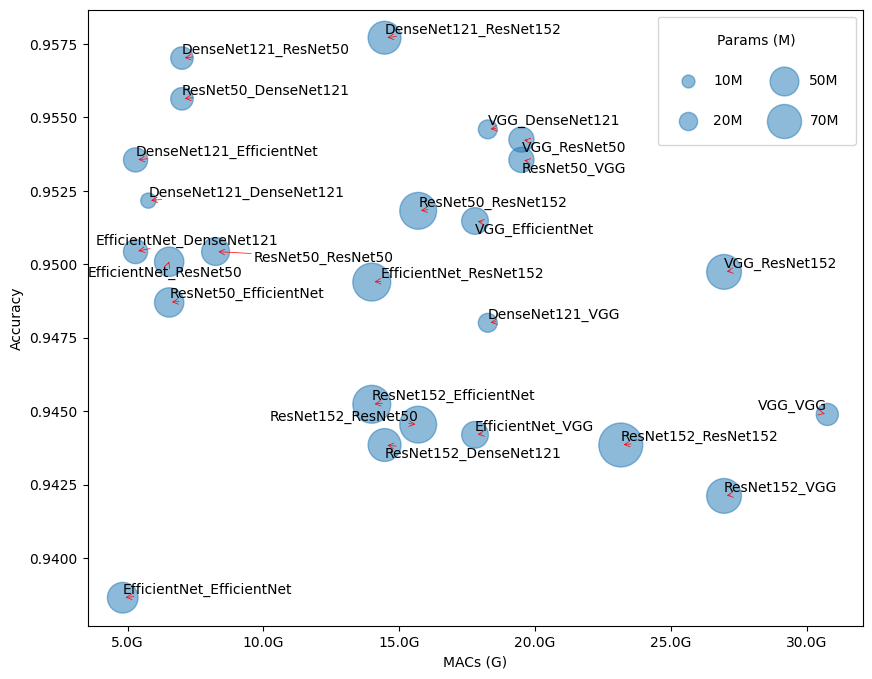

In [12]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
# Préparation des données pour le graphique
names = []
macs = []
accuracy = []
params = []
max_params = max(values['nb_parameters'] for values in all_outputs.values())
for name, values in all_outputs.items():
    names.append(name)
    macs.append(values['macs'] / 1e9)  # Convert MACs to GigaMACs
    accuracy.append(values['accuracy'])
    params.append((values['nb_parameters'] / max_params) * 1000)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(macs, accuracy, s=params, alpha=0.5, c='C0')

plt.xlabel('MACs (G)')
plt.ylabel('Accuracy')

# Format x-axis tick labels as scientific notation with "G" unit
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.offsetText.set_visible(False)
ax.xaxis.set_major_formatter('{x:.1f}G')
sizes = [10**7, 20*10**6, 50*10**6, 70*10**6]  # Define different sizes for the circles
labels = [f'{s/(10**6):.0f}M' for s in sizes]  # Define labels for the legend
handles = [plt.scatter([], [], s=(s/max_params)*1000, alpha=0.5,c="C0") for s in sizes]  # Create dummy scatter plots for the legend
legend = plt.legend(handles, labels, title='Params (M)', scatterpoints=1, labelspacing=1.9, loc='upper right',ncol=2,borderpad=1.2)
plt.setp(legend.get_title(), fontsize='medium')
# Ajout des annotations
texts = []
for x, y, s in zip(macs, accuracy, names):
    texts.append(plt.text(x, y, s))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.show()
fig.savefig("outputs/model_performance_plot_acc_mac.pdf",format="pdf")

### Table with results

In [13]:
dict_res = {key1: { key2 : round(all_outputs[key1][key2],3) for key2 in ["accuracy","balanced_accuracy","precision_micro","precision_weighted","recall_micro","f1_score_micro","f1_score_weighted"]} for key1 in all_outputs.keys() }
pd_res = pd.DataFrame(dict_res).transpose()
pd_res.columns = ["accuracy","balanced accuracy","precision micro","precision weighted","recall micro","f1-score micro","f1-score weighted"]
pd_res = pd_res.sort_values(by="accuracy",ascending=False)
pd_res

,accuracy,balanced accuracy,precision micro,precision weighted,recall micro,f1-score micro,f1-score weighted
DenseNet121_ResNet152,0.958,0.955,0.958,0.958,0.958,0.958,0.957
DenseNet121_ResNet50,0.957,0.954,0.957,0.957,0.957,0.957,0.957
ResNet50_DenseNet121,0.956,0.952,0.956,0.957,0.956,0.956,0.955
VGG_DenseNet121,0.955,0.952,0.955,0.955,0.955,0.955,0.954
VGG_ResNet50,0.954,0.951,0.954,0.955,0.954,0.954,0.954
DenseNet121_EfficientNet,0.954,0.951,0.954,0.954,0.954,0.954,0.953
ResNet50_VGG,0.954,0.950,0.954,0.954,0.954,0.954,0.953
ResNet50_ResNet152,0.952,0.948,0.952,0.953,0.952,0.952,0.951
DenseNet121_DenseNet121,0.952,0.949,0.952,0.953,0.952,0.952,0.952
VGG_EfficientNet,0.951,0.949,0.951,0.952,0.951,0.951,0.951


In [17]:
print(pd_res.style.to_latex())

\begin{tabular}{lrrrrrrr}
 & accuracy & balanced accuracy & precision micro & precision weighted & recall micro & f1-score micro & f1-score weighted \\
VGG_ResNet152 & 0.945000 & 0.941000 & 0.945000 & 0.946000 & 0.945000 & 0.945000 & 0.945000 \\
VGG_DenseNet121 & 0.937000 & 0.932000 & 0.937000 & 0.937000 & 0.937000 & 0.937000 & 0.936000 \\
VGG_ResNet50 & 0.935000 & 0.930000 & 0.935000 & 0.938000 & 0.935000 & 0.935000 & 0.935000 \\
DenseNet121_ResNet50 & 0.935000 & 0.930000 & 0.935000 & 0.936000 & 0.935000 & 0.935000 & 0.934000 \\
ResNet152_EfficientNet & 0.934000 & 0.928000 & 0.934000 & 0.934000 & 0.934000 & 0.934000 & 0.933000 \\
DenseNet121_VGG & 0.934000 & 0.929000 & 0.934000 & 0.934000 & 0.934000 & 0.934000 & 0.933000 \\
ResNet50_EfficientNet & 0.933000 & 0.927000 & 0.933000 & 0.934000 & 0.933000 & 0.933000 & 0.932000 \\
VGG_EfficientNet & 0.932000 & 0.929000 & 0.932000 & 0.932000 & 0.932000 & 0.932000 & 0.932000 \\
ResNet152_DenseNet121 & 0.932000 & 0.926000 & 0.932000 & 0.933000 

#### Matrice de confusion pour le meilleur modèle

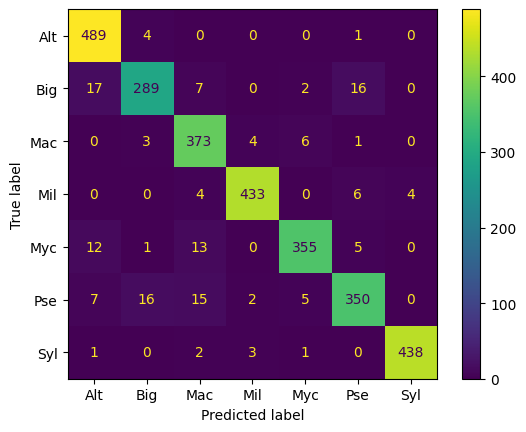

Accuracy : 0.9452339688041594
Balanced Accuracy : 0.940789919334004


In [27]:
y_pred=all_outputs['VGG_ResNet152']['pred']
#y_obs=real_labels
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
#y_pred=le.inverse_transform(y_pred)
y_obs=le.inverse_transform(y_obs)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))